In [69]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy


# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [70]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

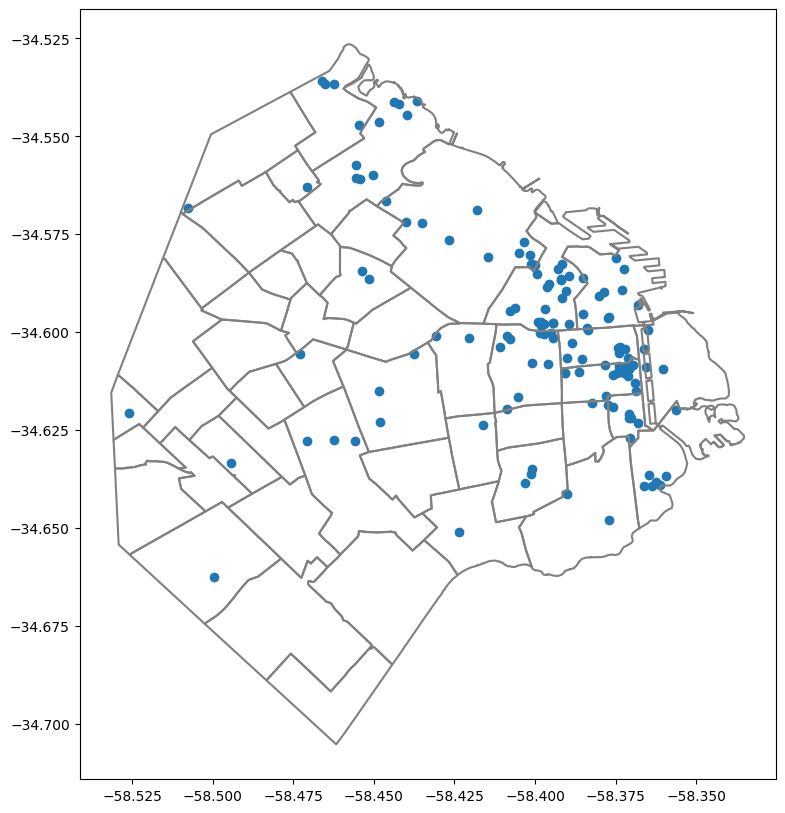

In [71]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [72]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [73]:
def construye_adyacencia(D,m): 
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [74]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

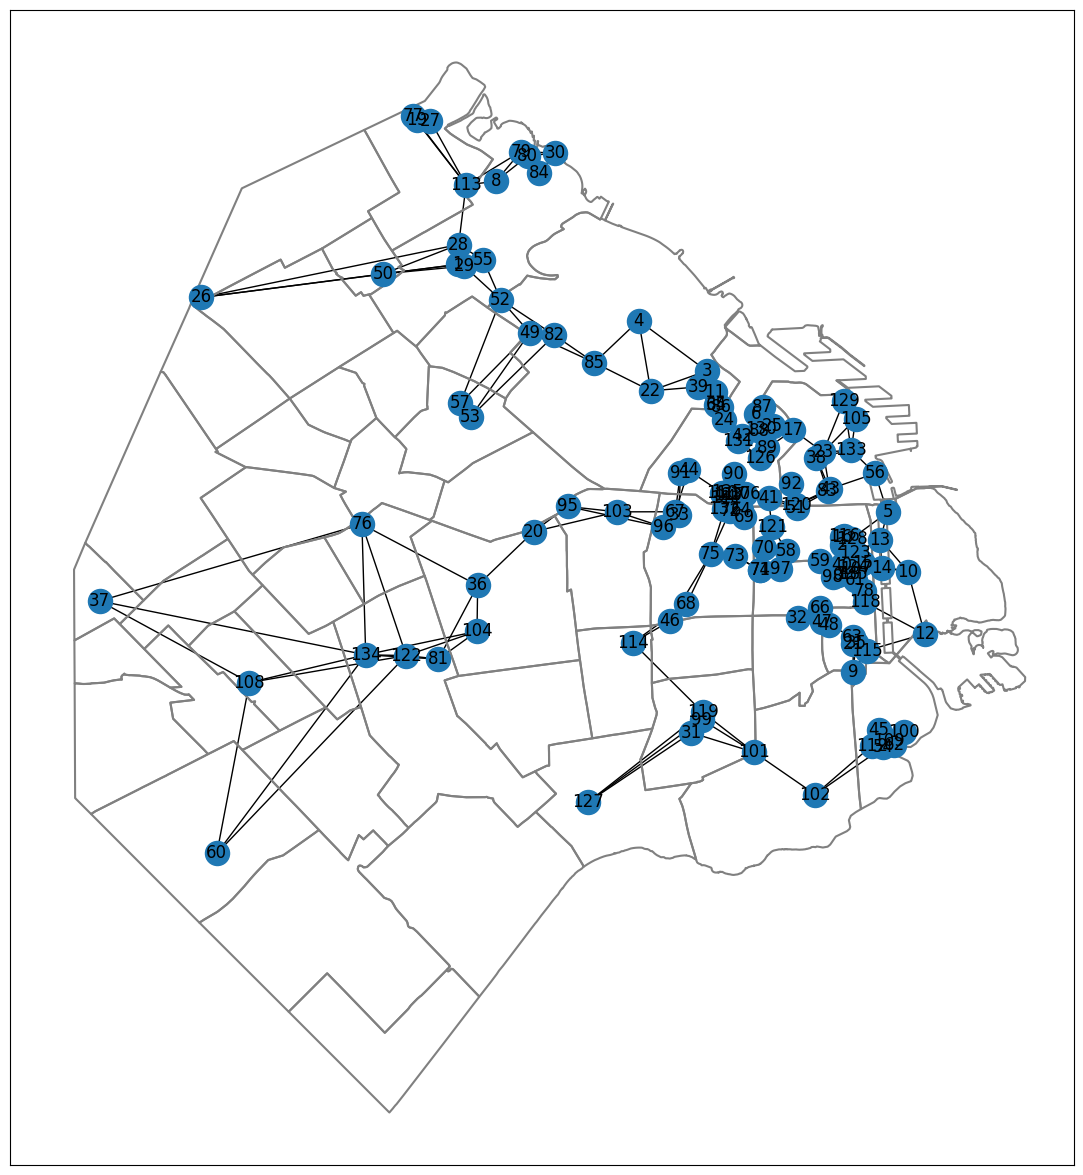

In [75]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## Punto 1:

In [76]:
def calcula_matriz_C(A): 
    # Función para calcular la matriz de trancisiones C
    # A: Matriz de adyacencia
    # Retorna la matriz C
    k = A.sum(axis=1)  # suma por filas: grado de cada página
    Kinv = np.diag([1/ki if ki != 0 else 0 for ki in k])
    C = A.T @ Kinv
    return C

def calcular_matriz_M(A, alfa):
    C = calcula_matriz_C(A)
    N = A.shape[0]
    I = np.eye(C.shape[0])
    M = (N / alfa) * (I - (1 - alfa) * C)
    return M



## Punto 2:


## Punto 3:

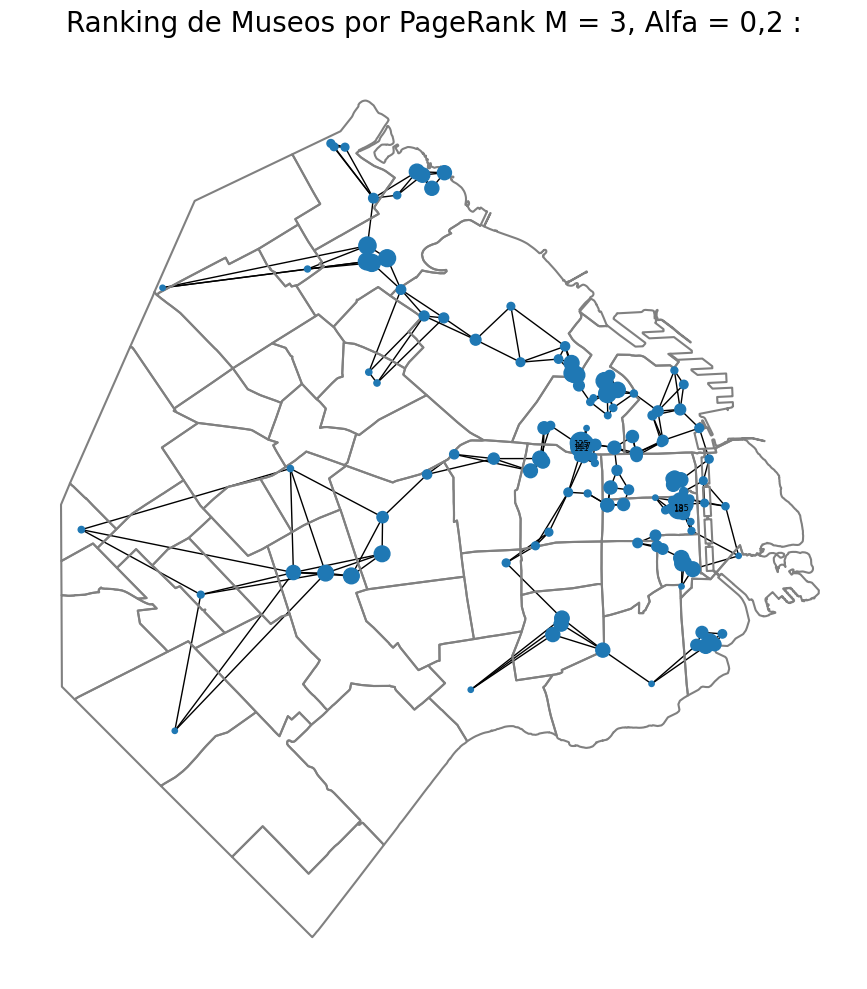

In [77]:
def calculaLU(A):
    # matriz es una matriz de NxN
    # Retorna la factorización LU a través de una lista con dos matrices L y U de NxN.
    # Completar! Have fun
    m=A.shape[0]
    n=A.shape[1]
    Ac = A.copy()
    
    if m!=n:
        print('Matriz no cuadrada')
        return
    

    for j in range(n):
        if Ac[j, j] == 0:
            raise ValueError(f"Pivote nulo en columna {j}. No se puede continuar sin pivoteo.")
        for i in range(j + 1, n):
            multiplicador = Ac[i, j] / Ac[j, j]
            Ac[i, j] = multiplicador  # <-- lo guardás acá
            Ac[i, j + 1:] = Ac[i, j + 1:] - multiplicador * Ac[j, j + 1:]
                
            
    L = np.tril(Ac,-1) + np.eye(A.shape[0]) 
    U = np.triu(Ac)
    
    return L, U

def calcula_pagerank(A,alfa):
    # Función para calcular PageRank usando LU
    # A: Matriz de adyacencia
    # d: coeficientes de damping
    # Retorna: Un vector p con los coeficientes de page rank de cada museo
    M = calcular_matriz_M(A, alfa)
    L, U = calculaLU(M) # Calculamos descomposición LU a partir de C y d
    N = A.shape[0]
    b = (N / alfa) * np.ones((N, 1)) # Vector de 1s, multiplicado por el coeficiente correspondiente usando d y N.
    Up = scipy.linalg.solve_triangular(L,b,lower=True) # Primera inversión usando L
    p = scipy.linalg.solve_triangular(U,Up) # Segunda inversión usando U
    return p.flatten()

def graficar_pagerak(A, pageRank, titulo = ""):
    factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
    fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
    pr = pageRank # Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
    pr = pr/pr.sum() # Normalizamos para que sume 1
    Nprincipales = 5 # Cantidad de principales
    principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
    labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
    red = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
    # Construimos un layout a partir de las coordenadas geográficas
    red_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}
    nx.draw_networkx(red,red_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
    nx.draw_networkx_labels(red, red_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres

    plt.title("Ranking de Museos por PageRank " + titulo + " :", fontsize=20, pad=20)  # Título grande y separado del gráfico
    plt.axis('off')  # Opcional, para ocultar ejes
    plt.tight_layout()
    plt.show()

m = 3 # Cantidad de links por nodo
mueseos_unidos_3 = construye_adyacencia(D,m)
pageRank = calcula_pagerank(mueseos_unidos_3, 0.2)

graficar_pagerak(mueseos_unidos_3, pageRank, "M = 3, Alfa = 0,2")



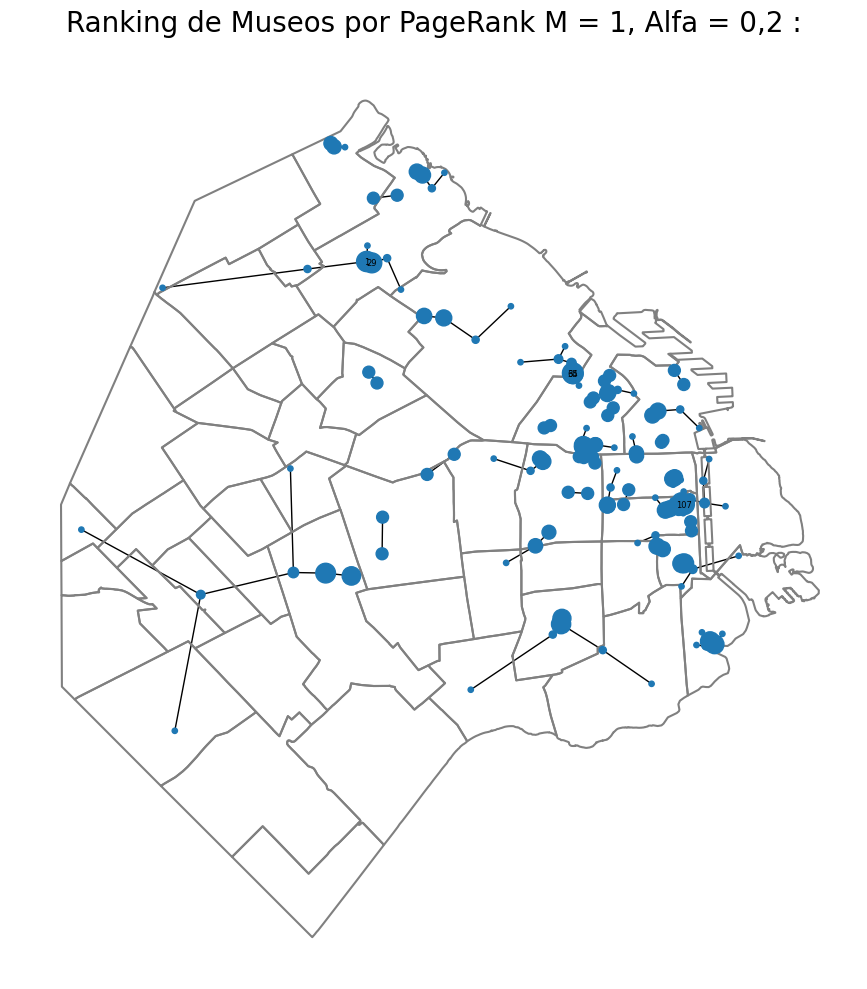

In [78]:
m = 1 # Cantidad de links por nodo
mueseos_unidos_1 = construye_adyacencia(D,m)
pageRank = calcula_pagerank(mueseos_unidos_1, 0.2)

graficar_pagerak(mueseos_unidos_1, pageRank, "M = 1, Alfa = 0,2")

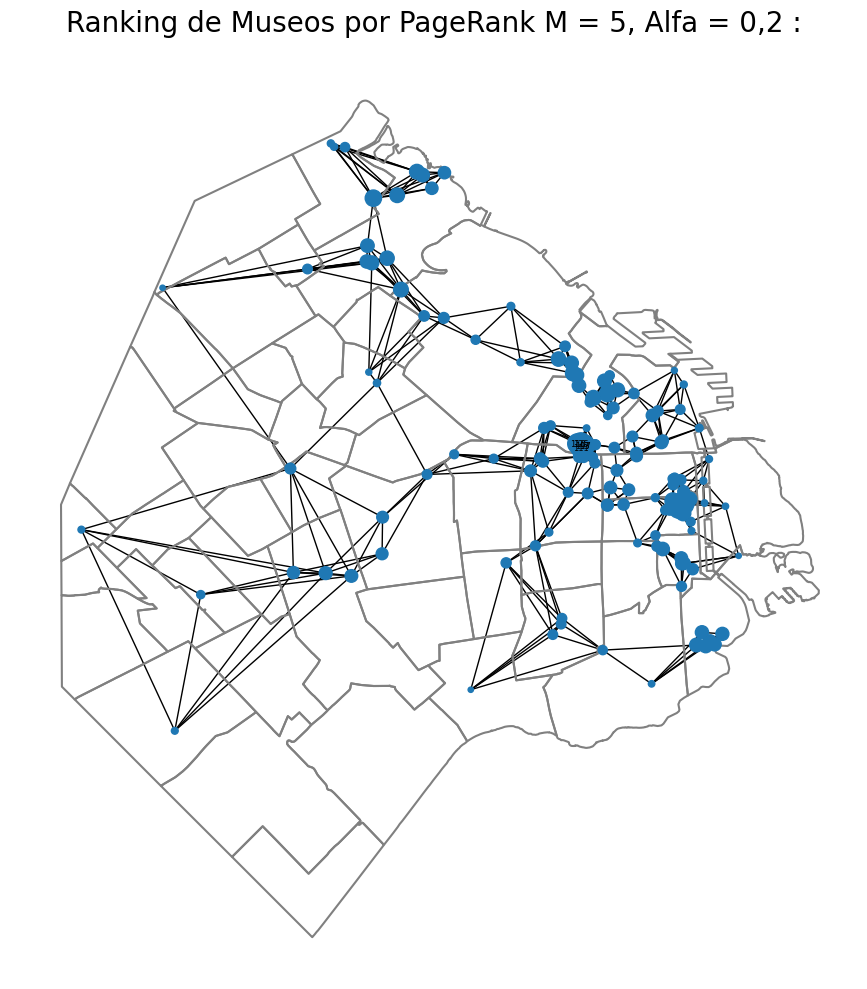

In [79]:
m = 5 # Cantidad de links por nodo
mueseos_unidos_5 = construye_adyacencia(D,m)
pageRank = calcula_pagerank(mueseos_unidos_5, 0.2)

graficar_pagerak(mueseos_unidos_5, pageRank, "M = 5, Alfa = 0,2")

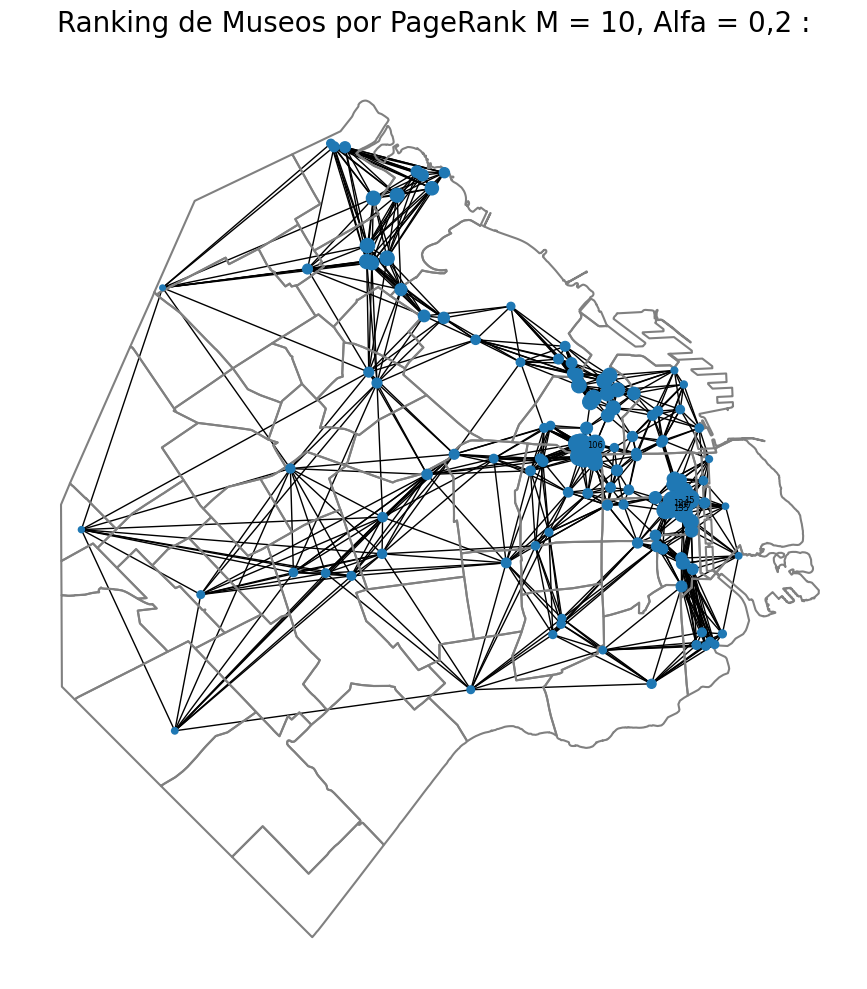

In [80]:
m = 10 # Cantidad de links por nodo
mueseos_unidos_10 = construye_adyacencia(D,m)
pageRank = calcula_pagerank(mueseos_unidos_10, 0.2)

graficar_pagerak(mueseos_unidos_10, pageRank, "M = 10, Alfa = 0,2")

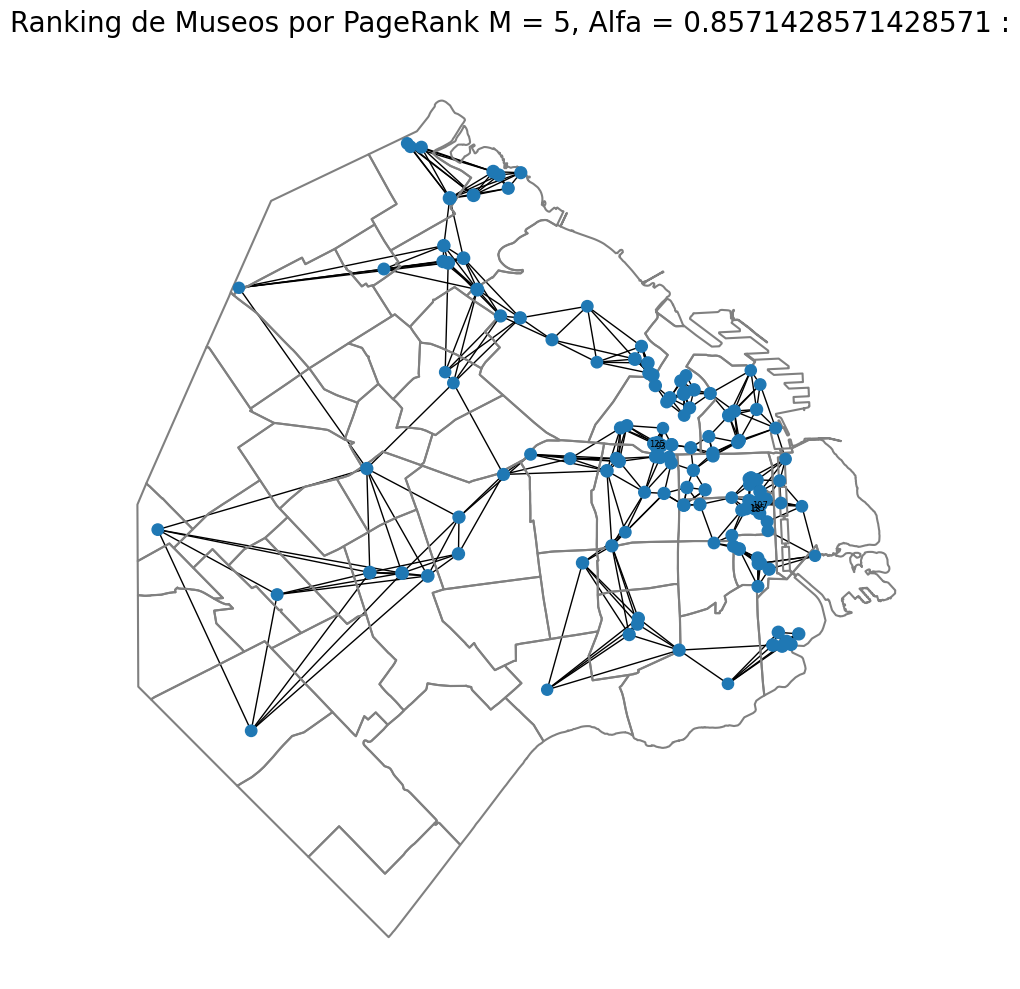

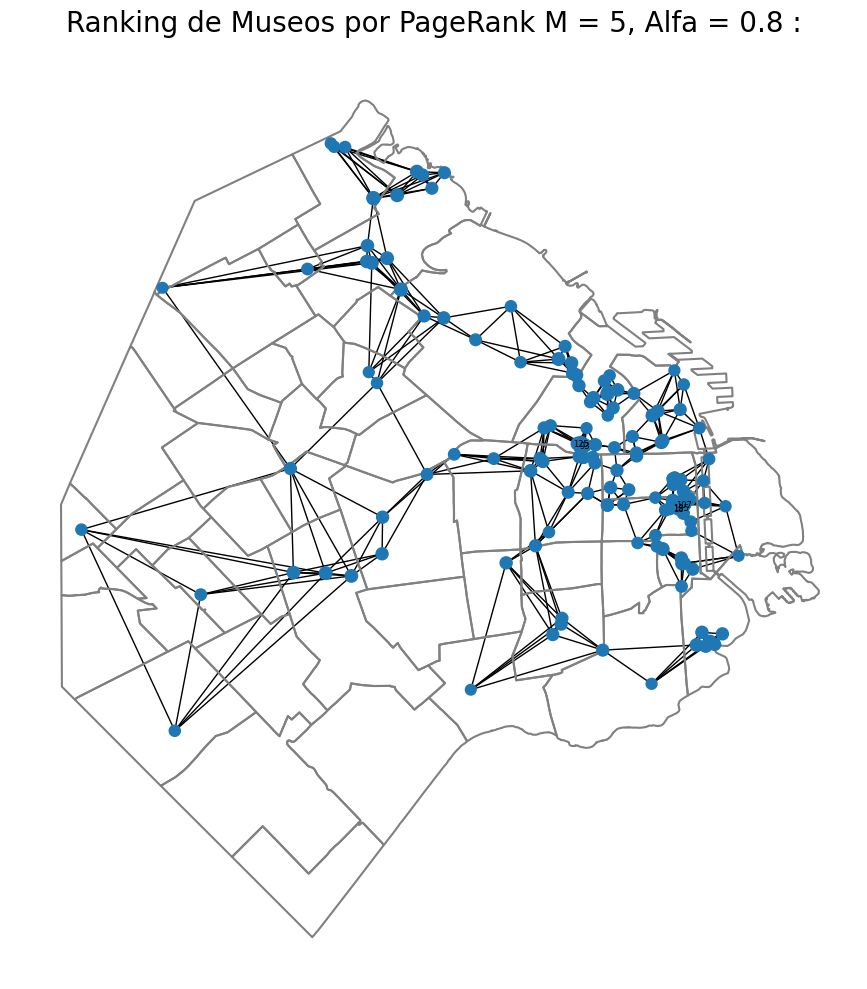

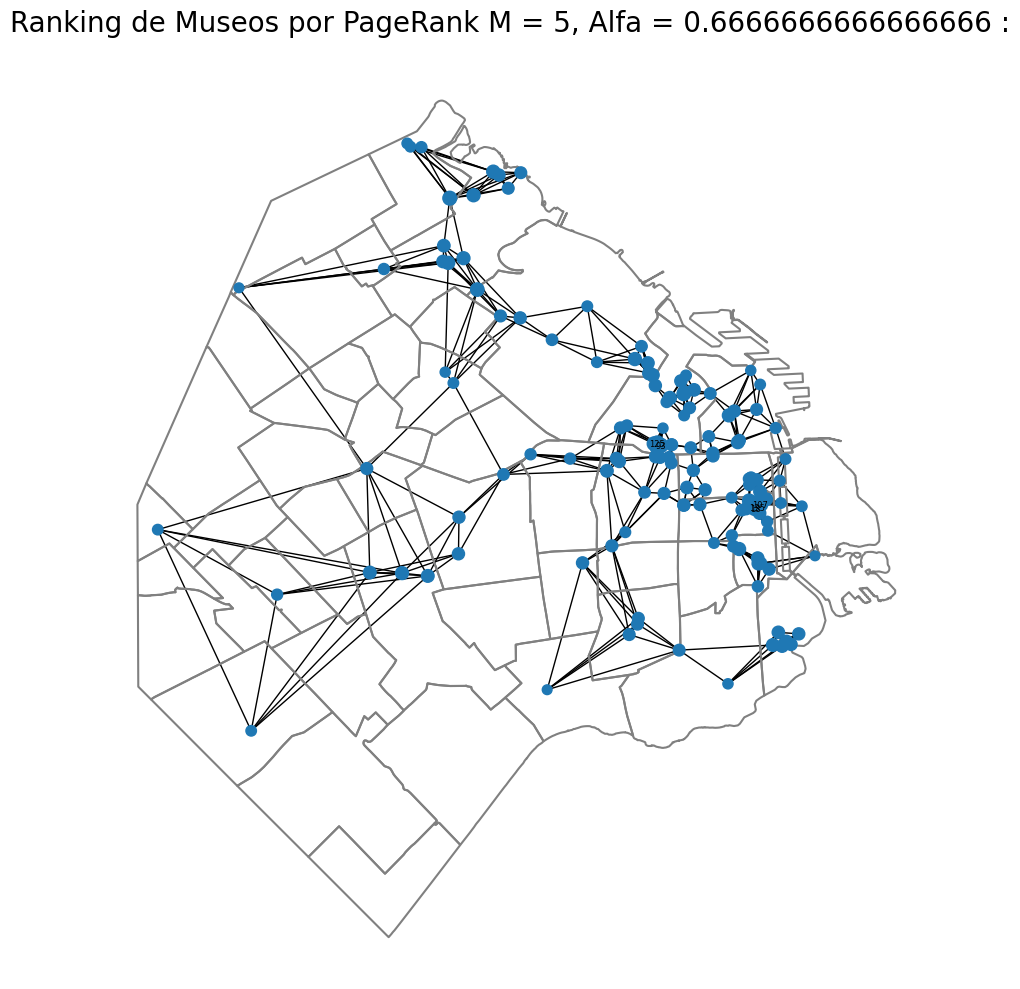

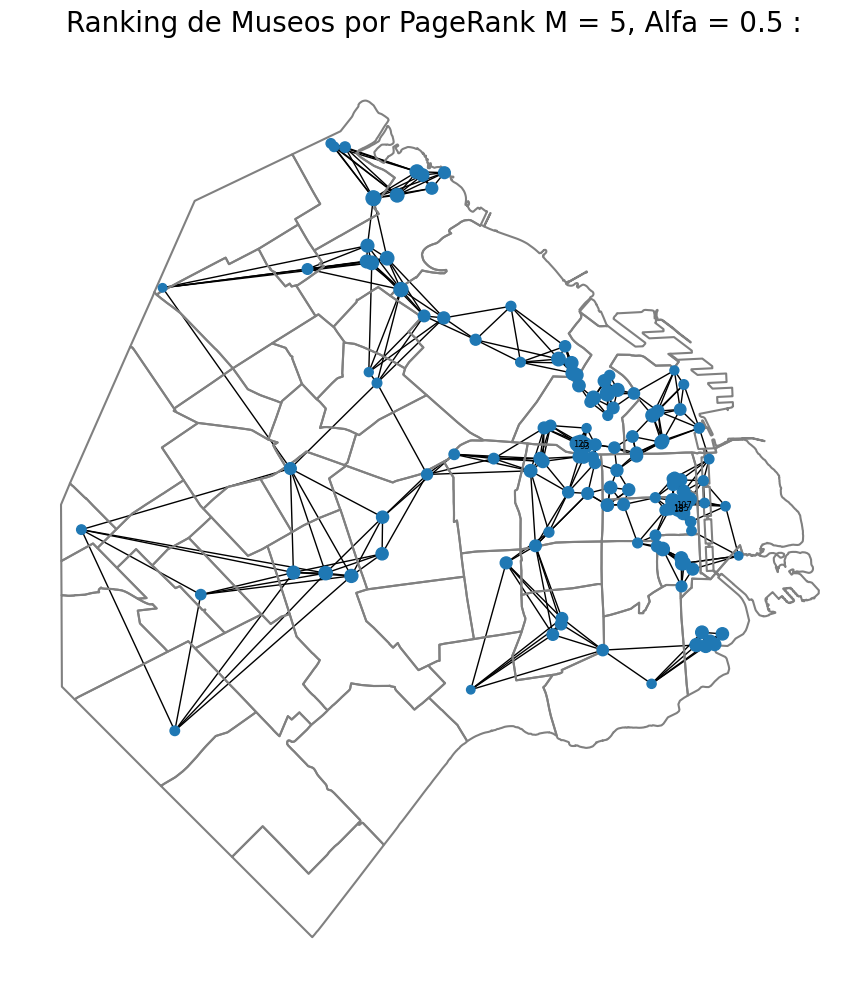

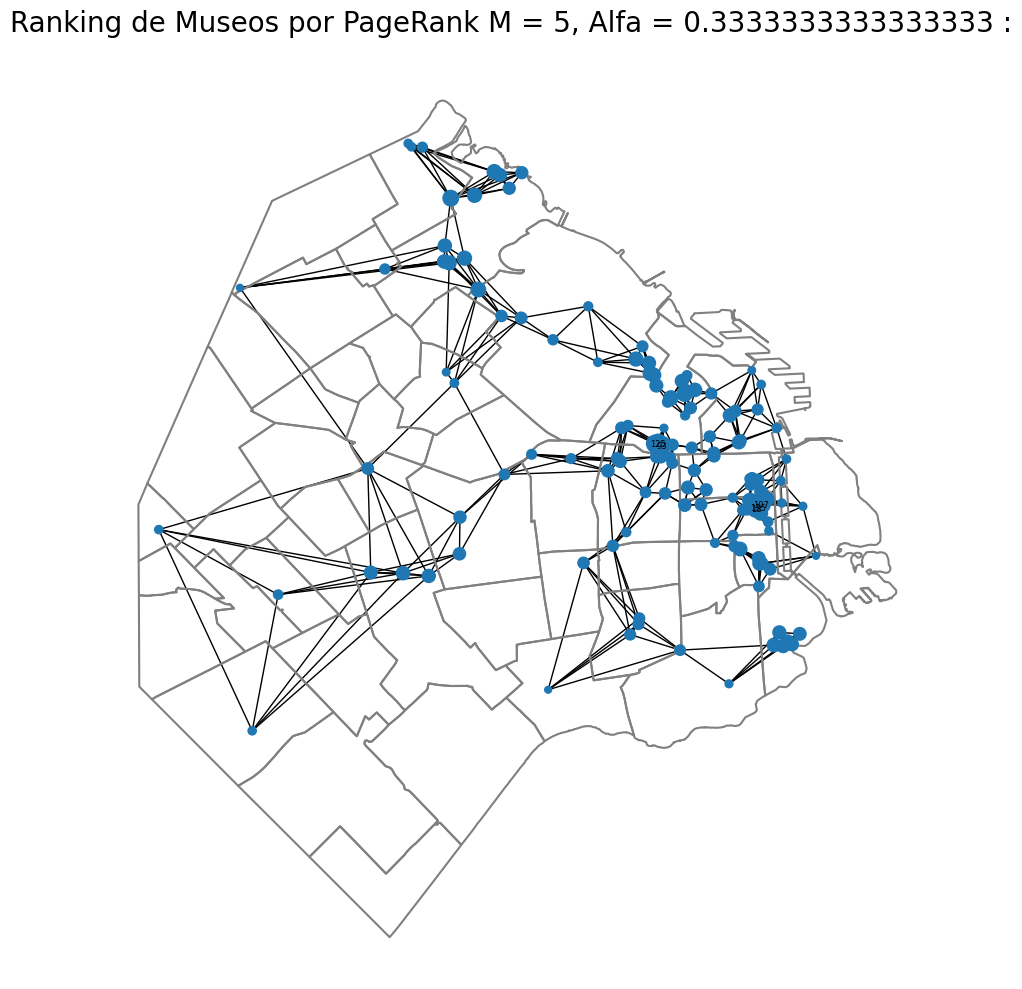

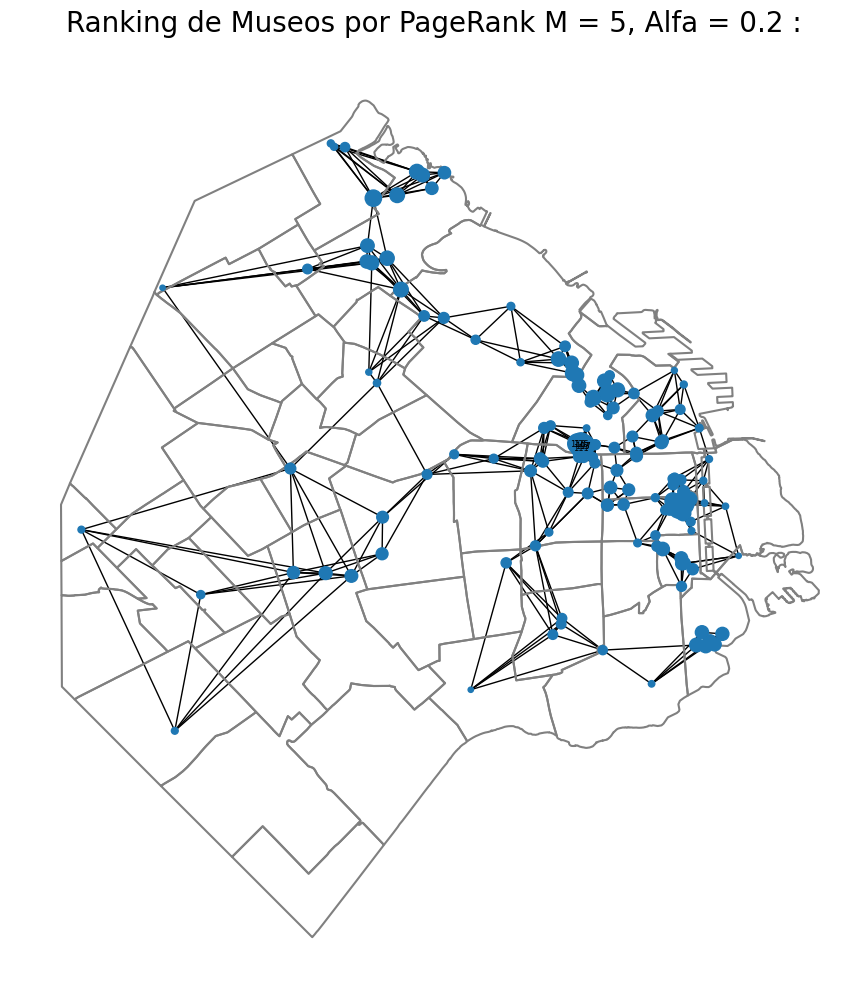

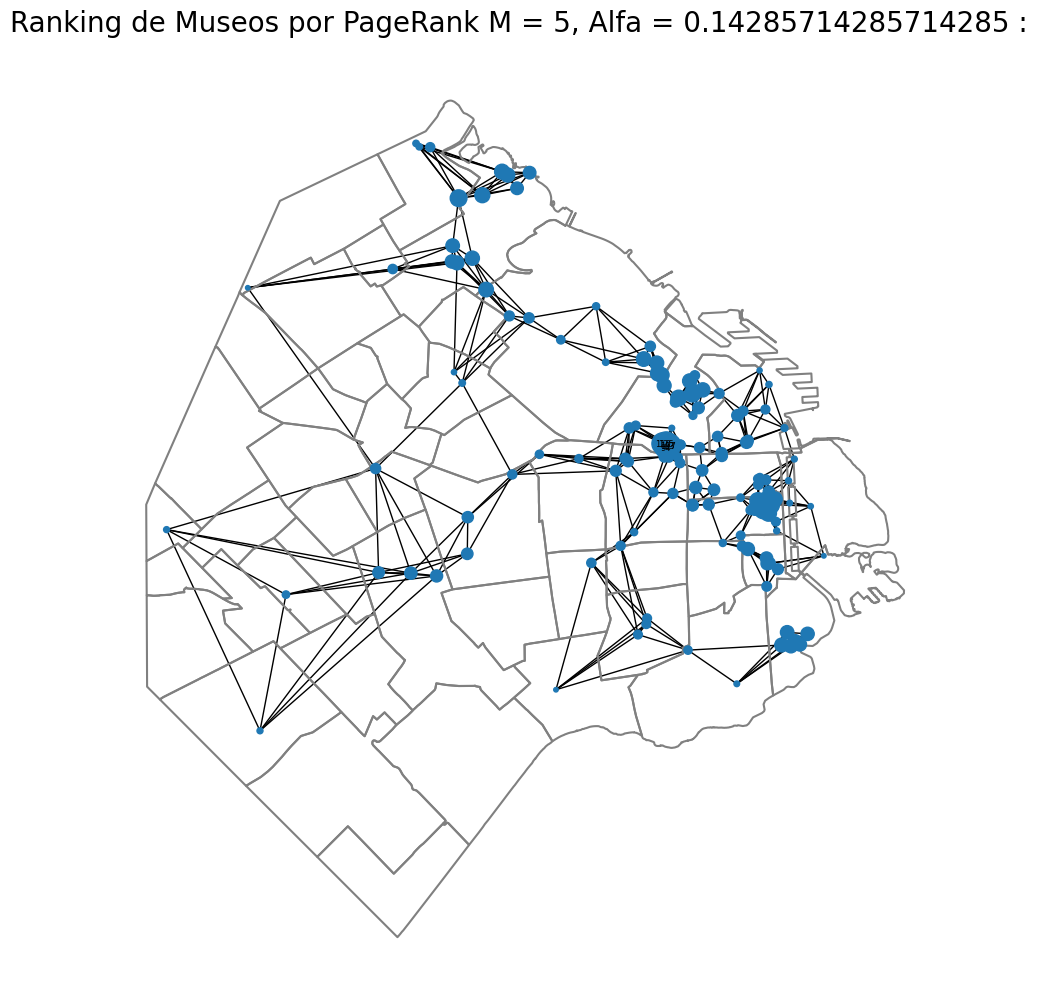

In [83]:
m = 5 # Cantidad de links por nodo
mueseos_unidos_5 = construye_adyacencia(D,m)
alfas = [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]
for alfa in alfas:
    pageRank = calcula_pagerank(mueseos_unidos_5, alfa)
    graficar_pagerak(mueseos_unidos_5, pageRank, f"M = 5, Alfa = {alfa}")

## Punto 4:

## Punto 5:

## Punto 6:

# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, '17'),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 1

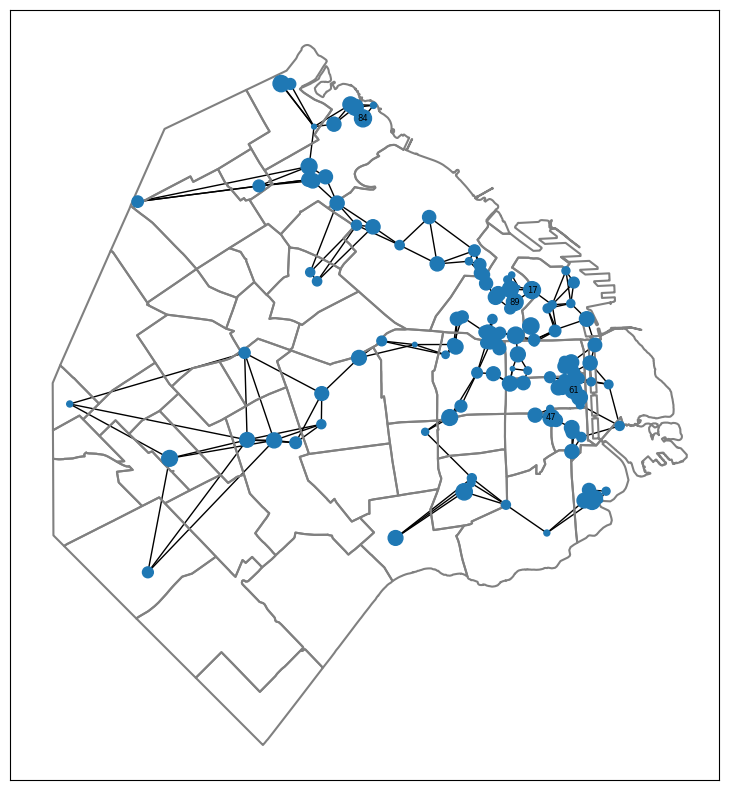

In [ ]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres